<a href="https://colab.research.google.com/github/Kozhedu/MOMO_2/blob/main/%D0%9C%D0%9E%D0%9C%D0%9E_%D0%A1%D0%9C_2_%D0%94%D0%97_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Импорт необходимых библиотек#

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from scipy.stats import norm
from scipy import stats

from sklearn.neighbors import KNeighborsRegressor # Регрессия К-Ближайших соседей от scikit-learn
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn

from sklearn.model_selection import train_test_split #  функция разбиения на тренировочную и тестовую выборку
from sklearn.preprocessing import MinMaxScaler # Объект Нормализации от Scikit-learn

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn.model_selection import RandomizedSearchCV # для поиска при случайном сэмплирование гиперпараметров
import scipy.stats as stats # статистические функции библиотеки scipy

from sklearn.model_selection import cross_validate

#Загрузка и предварительная обработка данных#

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/dayekb/Basic_ML_Alg/main/cars.csv', delimiter = ',') # можно считывать открытые файлы из интернета

In [ ]:
df.head(2)

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41007 entries, 0 to 41006
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  41007 non-null  object 
 1   Model                 41007 non-null  object 
 2   Year                  41007 non-null  int64  
 3   Style                 41007 non-null  object 
 4   Distance              41007 non-null  float64
 5   Engine_capacity(cm3)  41007 non-null  float64
 6   Fuel_type             41007 non-null  object 
 7   Transmission          41007 non-null  object 
 8   Price(euro)           41007 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 2.8+ MB


## 1.Обработка дубликатов##

In [ ]:
df.duplicated().sum()

3743

In [ ]:
df=df.drop_duplicates()

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.head(2)

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37264 entries, 0 to 41006
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  37264 non-null  object 
 1   Model                 37264 non-null  object 
 2   Year                  37264 non-null  int64  
 3   Style                 37264 non-null  object 
 4   Distance              37264 non-null  float64
 5   Engine_capacity(cm3)  37264 non-null  float64
 6   Fuel_type             37264 non-null  object 
 7   Transmission          37264 non-null  object 
 8   Price(euro)           37264 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 2.8+ MB


##2.Проверка на пропуски##

In [ ]:
df.isnull().sum()

Make                    0
Model                   0
Year                    0
Style                   0
Distance                0
Engine_capacity(cm3)    0
Fuel_type               0
Transmission            0
Price(euro)             0
dtype: int64

В результате предварительной обработки данных из данных удалены дубли. Пропуски в данных отсутствуют.

## 3. Анализ аномалий##

In [ ]:
df.describe()

,Year,Distance,Engine_capacity(cm3),Price(euro)
count,37264.000000,3.726400e+04,37264.000000,3.726400e+04
mean,2007.709264,4.758488e+05,1858.932535,9.569387e+03
std,8.295806,4.591520e+06,707.662731,5.283315e+04
min,1900.000000,0.000000e+00,0.000000,1.000000e+00
25%,2004.000000,9.000000e+04,1499.000000,3.300000e+03
50%,2009.000000,1.700000e+05,1800.000000,6.490000e+03
75%,2014.000000,2.300000e+05,2000.000000,1.179900e+04
max,2021.000000,1.000000e+08,9999.000000,1.000000e+07


Анализ основных статистическийх показателей выявил аномалии - например:

Мощность двигателя никак не может быть равно 0. 

Подозрительным выглядит Дистанция = 0, т.к автомобили продаются на вторичном рынке и никак не могут быть новыми.

Так-же нериальными выглядят максимальные значения в толбцах Цена и Дистанция

Рассмотрим более подробно аномалии.

In [ ]:
def destrib_fig(data, trait, n_bins=50, l_space_start=0, l_space_stop=0.5, l_space_count=10, dens=True): #Функция для построения гистограмм

    target_mean = round(data[trait].mean(), 2)
    target_median = data[trait].median()
    target_mode = data[trait].mode()[0]
    target_quant005 = data[trait].quantile(0.05)
    target_quant995 = data[trait].quantile(0.995)

    plt.figure(figsize = (13, 5))
    plt.hist(data[trait], density=dens, bins=n_bins, alpha=0.9, ec='Black',color = "navy" )

    y = np.linspace(l_space_start, l_space_stop, l_space_count)
    plt.plot([target_mean] * l_space_count, y, label='mean', linestyle='--', linewidth=2)
    plt.plot([target_median] * l_space_count, y, label='median', linestyle='--', linewidth=2)
    plt.plot([target_mode] * l_space_count, y, label='mode', linestyle='--', linewidth=2)
    plt.plot([target_quant005] * l_space_count, y, label='Quantile 0.05', linestyle='--',linewidth=2)
    plt.plot([target_quant995] * l_space_count, y, label='Quantile 0.995', linestyle='--',linewidth=2)
    plt.title(f'Гистограмма для переменной {trait}')
    plt.legend()
    plt.show()

###3.1. Мощность двигателя ##

<Figure size 1600x500 with 0 Axes>

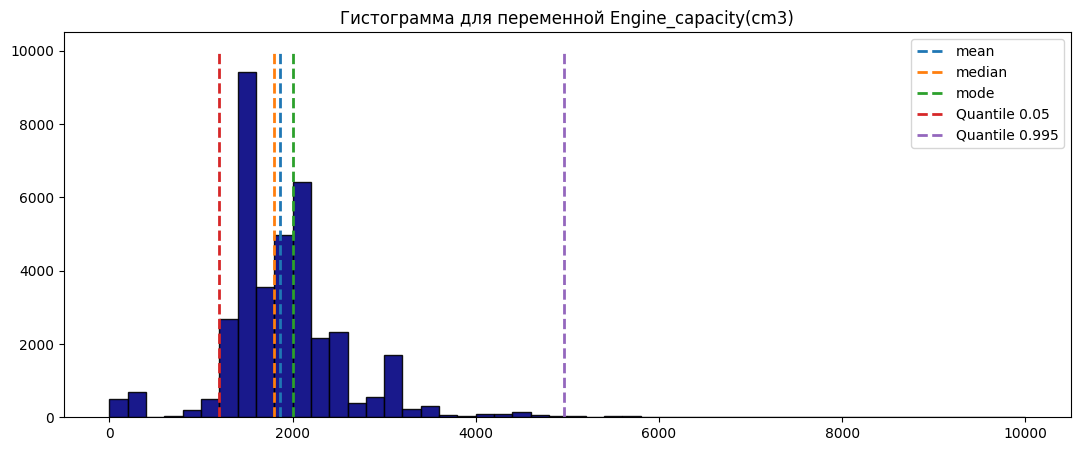

In [ ]:
plt.figure(figsize = (16,5))
destrib_fig(df, 'Engine_capacity(cm3)', dens=False, n_bins=50, l_space_stop=10000)

Удалим нулевые значения

In [ ]:
df = df[df['Engine_capacity(cm3)']>0]

In [ ]:
df['Engine_capacity(cm3)'].info()

<class 'pandas.core.series.Series'>
Int64Index: 37084 entries, 0 to 41006
Series name: Engine_capacity(cm3)
Non-Null Count  Dtype  
--------------  -----  
37084 non-null  float64
dtypes: float64(1)
memory usage: 579.4 KB


## 3.2. Анализ аномалий в показателе "Дистанция"

Возможно все авто, у которых дистанция = 0 - это новые авто? Проверим данное предположение

Text(0.5, 1.0, 'Количество авто с дистанцией 0 по годам выпуска')

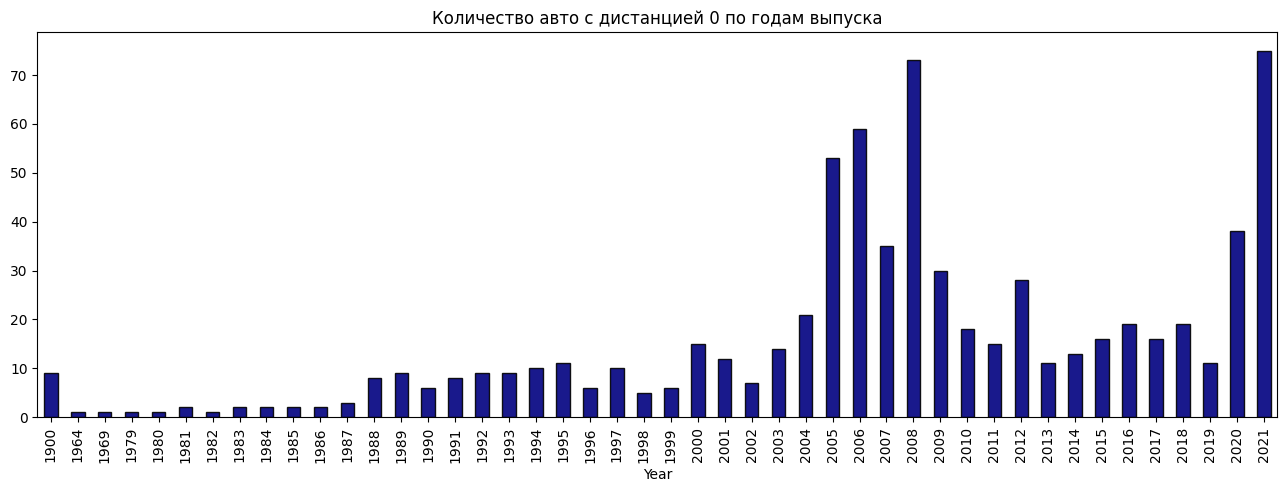

In [ ]:
plt.figure(figsize = (16,5))
df_di = df[df['Distance']==0].groupby(df['Year'])['Year'].count()
df_di.plot.bar(edgecolor='k', color = "navy", alpha=0.9)
plt.title("Количество авто с дистанцией 0 по годам выпуска")

К сожалению, предположение не верно и Дистанция = 0 действительно является аномалией. Удалим данную аномалию из данных

In [ ]:
df = df[df['Distance']>0]
df['Distance'].info()

<class 'pandas.core.series.Series'>
Int64Index: 36362 entries, 0 to 41006
Series name: Distance
Non-Null Count  Dtype  
--------------  -----  
36362 non-null  float64
dtypes: float64(1)
memory usage: 568.2 KB


Очень большая дистанция выглядит так-же очень подозрительно и нереально. Удалим данное значение и посмотрим, что получилось

In [ ]:
question_dist = df[(df.Distance > 1e6)]
df = df.drop(question_dist.index)

<Figure size 1600x500 with 0 Axes>

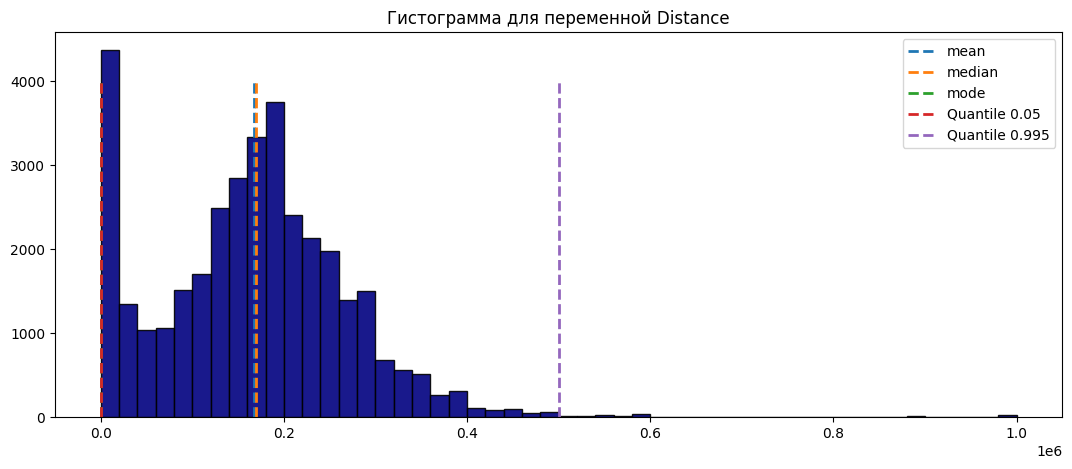

In [ ]:
plt.figure(figsize = (16,5))
destrib_fig(df, 'Distance', dens=False, n_bins=50, l_space_stop=4000)

In [ ]:
df['Distance'].info()

<class 'pandas.core.series.Series'>
Int64Index: 35771 entries, 0 to 41006
Series name: Distance
Non-Null Count  Dtype  
--------------  -----  
35771 non-null  float64
dtypes: float64(1)
memory usage: 558.9 KB


## 3.3. Показатель "Цена"

Анализ основных статистических показателе так-же выявил аномалию по показателю цена - удалим очень высокую и низкую цену и посмотрим на гистограмму

In [ ]:
question_price = df[df["Price(euro)"] > 1e5]
df = df.drop(question_price.index)

In [ ]:
question_price = df[df["Price(euro)"] < 2]
df = df.drop(question_price.index)

<Figure size 1600x500 with 0 Axes>

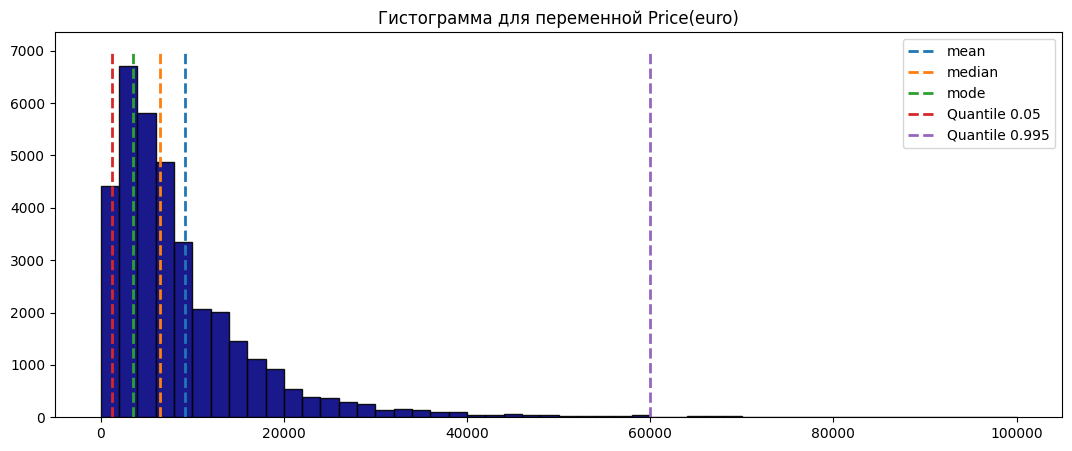

In [ ]:
plt.figure(figsize = (16,5))
destrib_fig(df, 'Price(euro)', dens=False, n_bins=50, l_space_stop=7000)

In [ ]:
df['Price(euro)'].info()

<class 'pandas.core.series.Series'>
Int64Index: 35738 entries, 0 to 41006
Series name: Price(euro)
Non-Null Count  Dtype  
--------------  -----  
35738 non-null  float64
dtypes: float64(1)
memory usage: 558.4 KB


После предварительной обработки данных в датасете осталось 35 738 записей

#EDA Анализ зависимости целевой переменной от прочих признаков#

##1. Оценка связи числовых признаков с целевой переменной##

<ipython-input-25-3a1e446289cc>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


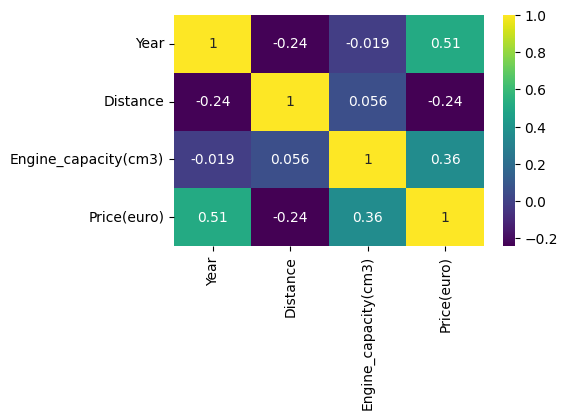

In [ ]:
plt.figure(figsize = (5,3))
corr = df.corr()
sns.heatmap(corr, cmap="viridis", annot = True);

Какой либо существенной зависимости стоимости авто от прочих числовых признаков не обнаружено

Text(0.5, 1.0, 'Средняя цена от года выпуска')

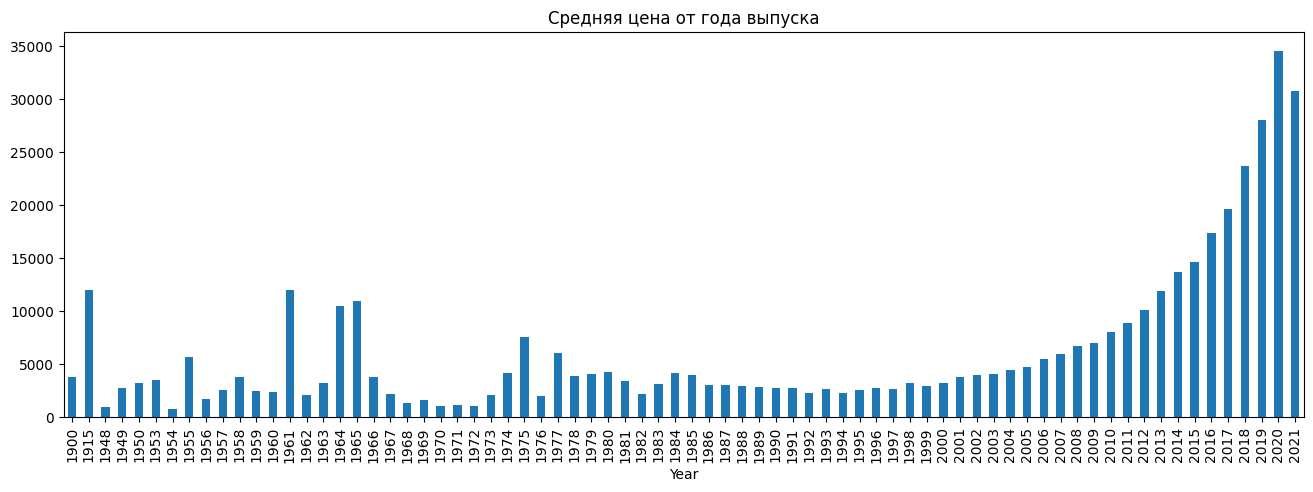

In [ ]:
# посмотрим насколько средняя цена зависит от года выпуска
plt.figure(figsize = (16,5))
df.groupby(df['Year'])['Price(euro)'].mean().plot.bar()
plt.title('Средняя цена от года выпуска')

Логично, что чем старше авто, тем оно будет стоить дешевле

<ipython-input-27-fc8cb3ef30fb>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x = "Distance", y = "Price(euro)", alpha=.5, palette="dark:#5A9_r")


Text(0.5, 1.0, 'Зависимость цены от дистанции')

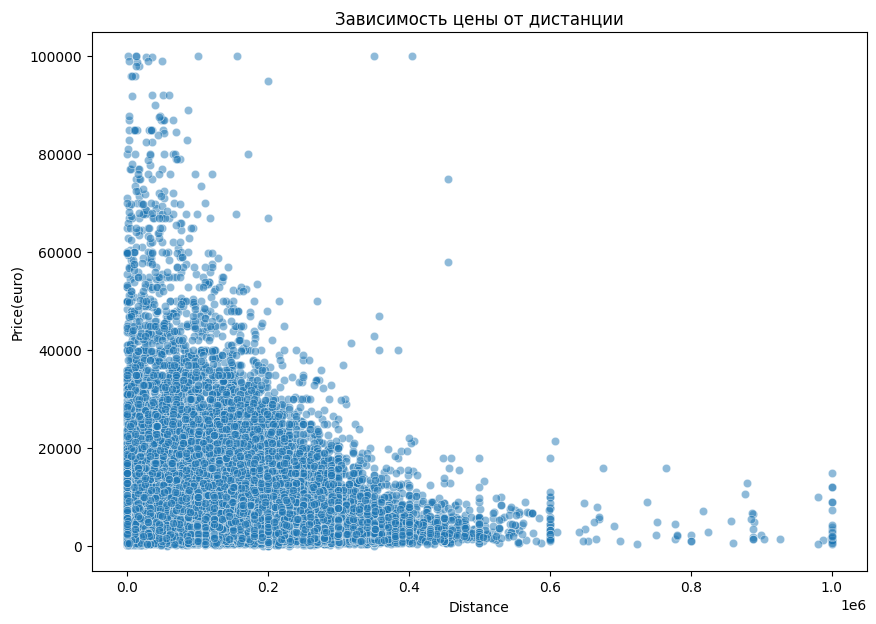

In [ ]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=df, x = "Distance", y = "Price(euro)", alpha=.5, palette="dark:#5A9_r")
plt.title("Зависимость цены от дистанции")

Какой-либо существенной зависимости цены от дистанции не наблюдается.

## 2. Оценка связи числовых признаков с целевой переменной ##

Проверим, зависит-ли цена от Марки машины

Text(0.5, 1.0, 'Средняя цена на авто в зависимости от Марки')

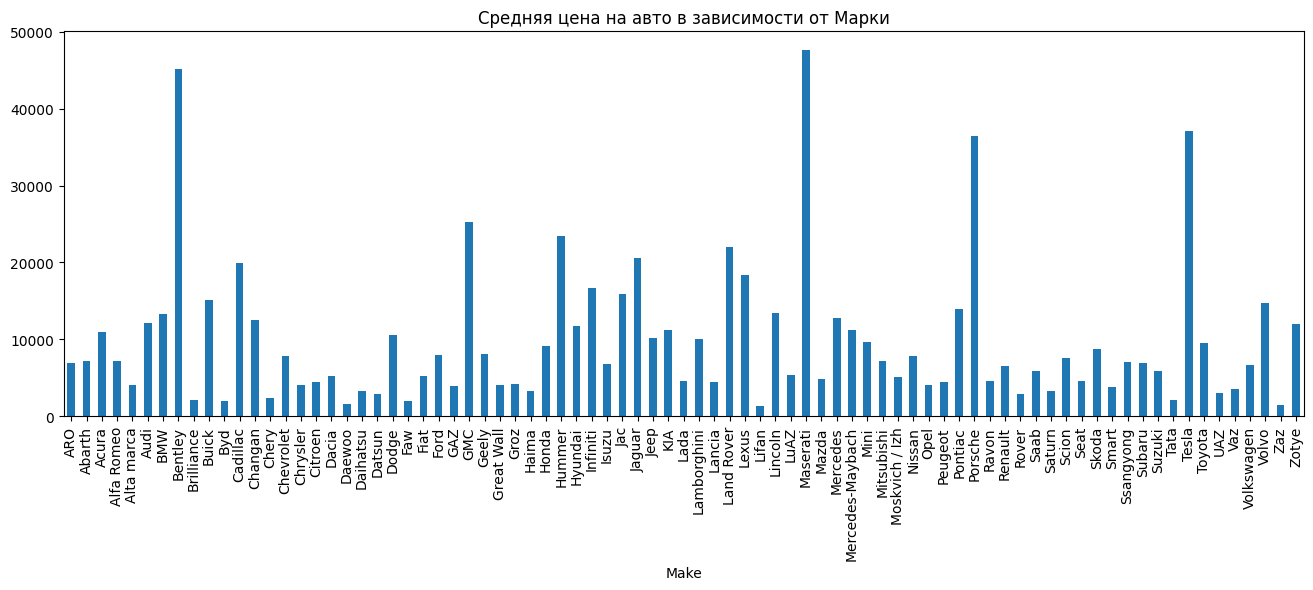

In [ ]:
plt.figure(figsize=(16,5))
df.groupby(df['Make'])["Price(euro)"].mean().plot.bar()
plt.title('Средняя цена на авто в зависимости от Марки')

Конечно-же, чем престижнее марка авто, тем цена дороже. Например цена на  Maserati и BMV на порядок выше, чем стоимость того-же ZAZ. т.о. можно сделать вывод о прямой зависимости цены авто от марки.

Завсисмость цены авто от Transmission

Text(0.5, 1.0, 'Средняя цена на авто в зависимости от Transmission')

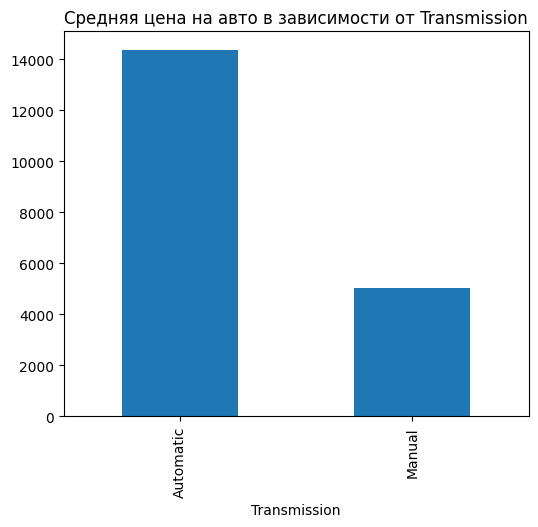

In [ ]:
plt.figure(figsize=(6,5))
df.groupby(df['Transmission'])["Price(euro)"].mean().plot.bar()
plt.title('Средняя цена на авто в зависимости от Transmission')

In [ ]:
yprop = 'Price(euro)'
xprop = 'Engine_capacity(cm3)'
h= 'Transmission'
px.scatter(df, x=xprop, y=yprop, color=h, marginal_y="violin", marginal_x="box", trendline="ols", template="simple_white")


По графикам можно сделать вывод - что по автомобилям с автоматической коробкой передач цена в среднем выше, чем по авто с ручным управлением, даже не смотря на то, что по авто с ручным управлением имеются автомобили с более мощным двигателем, чем у автоматической коробки передач.

#Добавление в данные дополнительных признаков#

#1. Разделим авто на старые и новые, т.к. в EDA анализе было видно, что начиная с 2000 года цена на авто начинает расти#

In [ ]:
def yer(x):
  if x < 2000:
    return "old"
  else:
    return "new"

In [ ]:
df['new_old'] = df['Year'].apply(yer)

In [ ]:
df.head(2)

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),new_old
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0,new
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0,new


##2. Создадим квантильные категории для столбца удельный пробег за год (km year) - категории «с небольшим пробегом», «со средним пробегом» и «с большим пробегом» ##

In [ ]:
df['Age'] = 2023 - df.Year
df['km_year'] = df.Distance/df.Age

In [ ]:
bin= ['little_mileage', 'average_mileage', 'high_mileage']

df['km_year_q'] = pd.qcut(df['km_year'],
                              q = [0, 1/3, 2/3, 1],
                              labels=bin)
df.head()

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),new_old,Age,km_year,km_year_q
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0,new,12,16250.000000,high_mileage
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0,new,9,15000.000000,average_mileage
2,Volkswagen,Golf,1998,Hatchback,1.0,1400.0,Petrol,Manual,2200.0,old,25,0.040000,little_mileage
3,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0,new,11,10000.000000,average_mileage
4,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0,new,17,11764.705882,average_mileage


## 3. «Умная» замена на редкие категории. В этот раз делайте замену вида «редкий дорогой» и «редкий дешевый», чтобы условные УАЗики не попали в одну группу с Jaguar##

Разделим авто на дорогие и дешевые. Для этого посчитаем для каждого авто среднюю стоимость и потом определив медиану разделим авто на 2 группы - дорогие и дешевые.

In [ ]:
h = df.pivot_table(index = (df['Make']), values= "Price(euro)", aggfunc='mean').sort_values(by='Price(euro)', ascending=False)
h = h.reset_index().rename_axis(None, axis=1)
h.median()

<ipython-input-36-cfda4e8976bc>:3: FutureWarning:

The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



Price(euro)    7135.352941
dtype: float64

In [ ]:
#создадим переменную, у которой каждое значение – частота наблюдений в категории переменных (Make)
val = df['Make'].value_counts()
df['Make_val'] = df['Make'].map(val)

In [ ]:
# создадим функцию для переменной, у которой каждое значение - среднее значение количественной переменной, взятое по уровню категориальной переменной
def code_mean(df, cat_feature, real_feature):
    return (df[cat_feature].map(df.groupby(cat_feature)[real_feature].mean()))

In [ ]:
df['Price_mean_make'] = code_mean(df, 'Make', 'Price(euro)')

In [ ]:
#по условию в задании  заменим редкие категории
df.loc[(df['Price_mean_make'] < 7169) & (df['Make_val'] < 25), 'Make'] = 'Rare_cheap'
df.loc[(df['Price_mean_make'] >= 7169) & (df['Make_val'] < 25), 'Make'] = 'Rare_expensive'

In [ ]:
df

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),new_old,Age,km_year,km_year_q,Make_val,Price_mean_make
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0,new,12,16250.000000,high_mileage,3322,9554.353402
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0,new,9,15000.000000,average_mileage,2587,6515.357170
2,Volkswagen,Golf,1998,Hatchback,1.0,1400.0,Petrol,Manual,2200.0,old,25,0.040000,little_mileage,3801,6672.530650
3,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0,new,11,10000.000000,average_mileage,2587,6515.357170
4,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0,new,17,11764.705882,average_mileage,2115,4089.911584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41001,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0,new,21,10714.285714,average_mileage,307,21981.218241
41002,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0,new,8,11125.000000,average_mileage,1473,5241.370672
41003,Renault,Modus,2009,Hatchback,225.0,1500.0,Diesel,Manual,4500.0,new,14,16.071429,little_mileage,2587,6515.357170
41005,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0,new,17,21764.705882,high_mileage,506,4894.318182


##Кодирование категориальных данных##

In [ ]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

In [ ]:
cols=np.array(df.columns[df.dtypes != object])
d = defaultdict(LabelEncoder)

In [ ]:
cols

array(['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'Age',
       'km_year', 'km_year_q', 'Make_val', 'Price_mean_make'],
      dtype=object)

In [ ]:
df = df.apply(lambda x: d[x.name].fit_transform(x))

In [ ]:
df

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),new_old,Age,km_year,km_year_q,Make_val,Price_mean_make
0,42,560,63,4,5136,329,2,0,529,0,10,9394,1,55,51
1,34,379,66,11,3046,261,0,1,591,0,7,8567,0,53,35
2,45,371,50,4,0,213,4,1,161,1,23,26,2,57,36
3,34,441,64,11,2412,261,0,1,454,0,9,4991,0,53,35
4,29,145,58,11,5330,291,3,1,285,0,15,6155,0,52,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41001,20,342,54,3,6151,329,3,1,308,0,19,5466,0,35,74
41002,7,455,67,11,1983,261,0,1,489,0,6,5720,0,48,31
41003,34,489,61,4,164,261,0,1,318,0,12,695,2,53,35
41005,23,82,58,1,8192,397,0,1,279,0,15,11678,1,39,28


#Cвязь конечных признаков с целевой переменной#

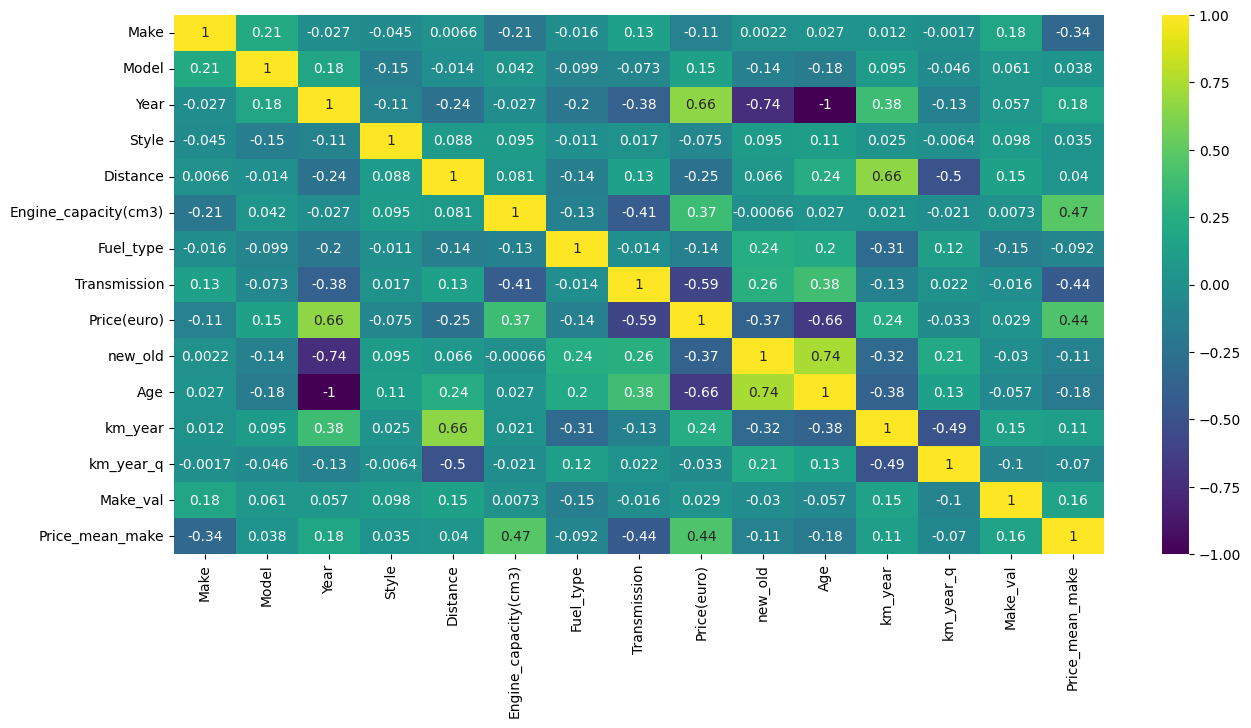

In [ ]:
plt.figure(figsize = (15,7))
corr = df.corr()
sns.heatmap(corr, cmap="viridis", annot = True);

#Преобразование числовых переменных#

###Distance###

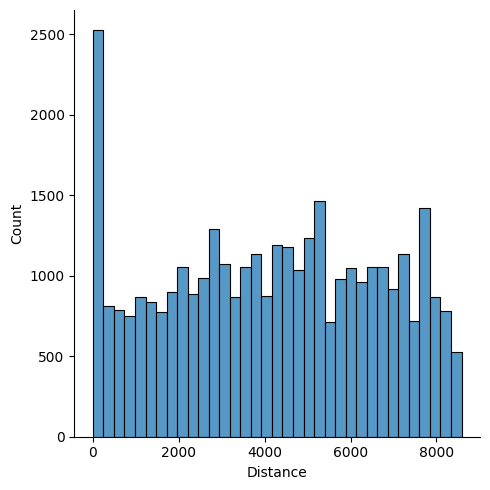

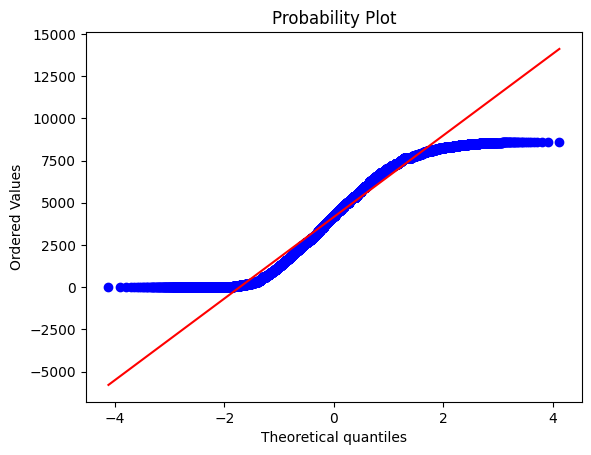

In [ ]:
sns.displot(df['Distance'])
fig = plt.figure()
res = stats.probplot(df['Distance'], plot=plt)

В дистанции мы наблюдаем правостороннюю асимметрию. Посмотрим, сможет-ли решить проблему с помощью логарифмического преобразования

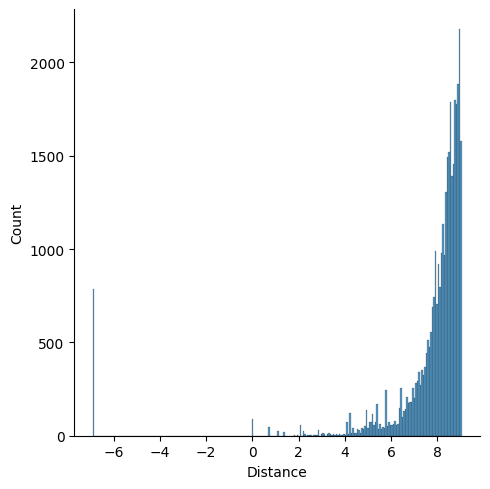

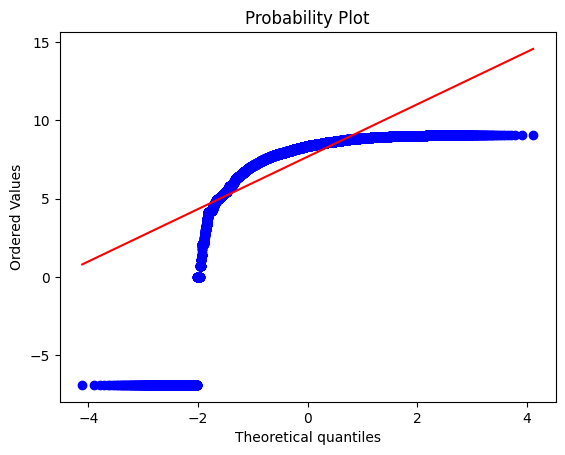

In [ ]:
a = 0.001
sns.displot(np.log(df['Distance']+a))
fig = plt.figure()
res = stats.probplot(np.log(df['Distance']+a), plot=plt)

Логарифм не дал улучший результат. Стало даже хуже. Попробуем свернутый корень

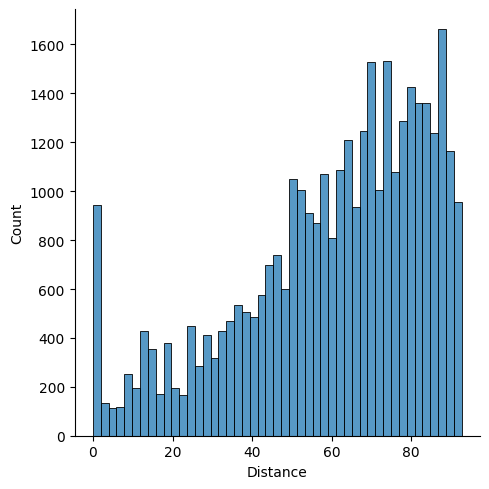

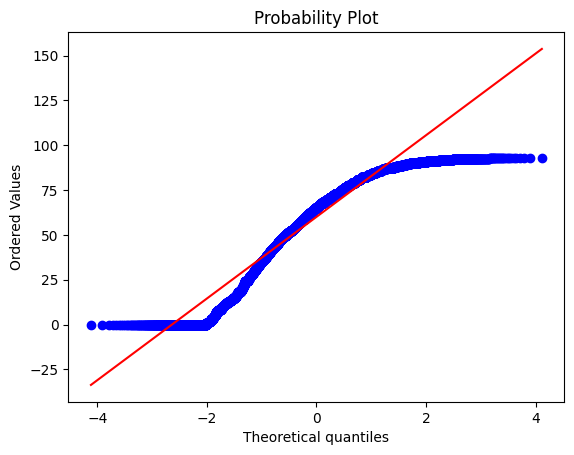

In [ ]:
sns.displot(np.sign(df['Distance'])* np.sqrt(df['Distance'].abs()))
fig = plt.figure()
res = stats.probplot(np.sign(df['Distance'])* np.sqrt(df['Distance'].abs()), plot=plt)

Стало конечно лучше, чем было, однако все рано не то, что ожидала. Единственный вариан - удалить выбросы с помощью квантилей.

Данные являются выбросом, если они превышают 0,5* IQR выше третьего квартиля или ниже первого квартиля, где IQR разница между третьим и первым квартилем.

In [ ]:
Q1 =  df['Distance'].quantile(0.25)
Q3 = df['Distance'].quantile(0.75)
IQR = Q3 - Q1
df= df[(df['Distance'] > (Q1-0.5*IQR)) & (df['Distance'] < (Q3+0.5*IQR))]
df["Distance"].describe()

count    33688.000000
mean      4279.862473
std       2323.107233
min         90.000000
25%       2420.000000
50%       4358.500000
75%       6274.000000
max       8335.000000
Name: Distance, dtype: float64

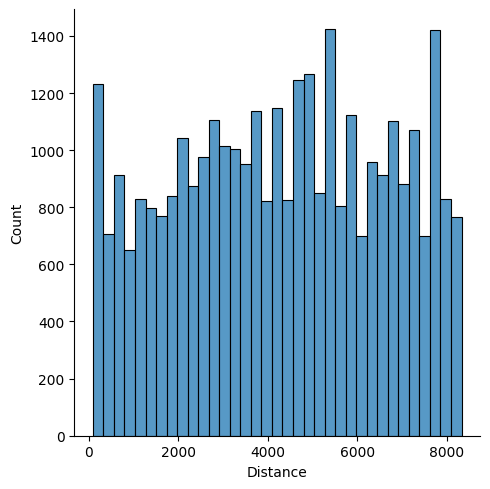

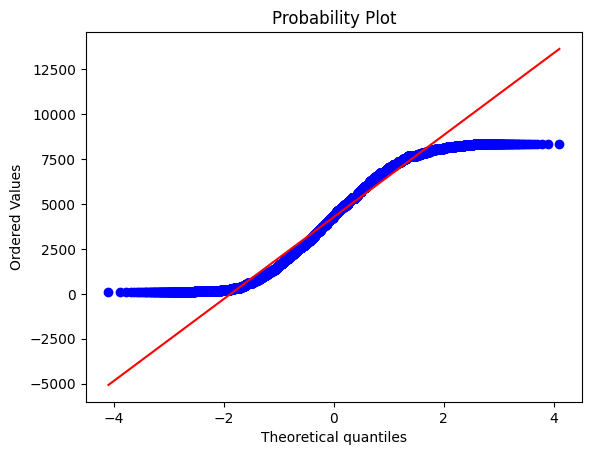

In [ ]:
sns.displot(df['Distance'])
fig = plt.figure()
res = stats.probplot(df['Distance'], plot=plt)

Данных мы удалили не так много, зато данные стали более нормальными. Посмотрим другие данные

###Engine_capacity(cm3)###

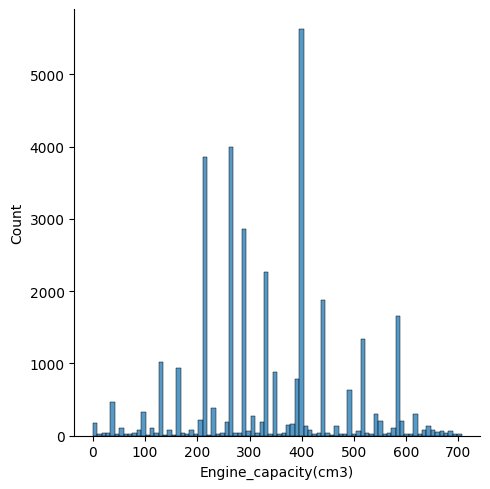

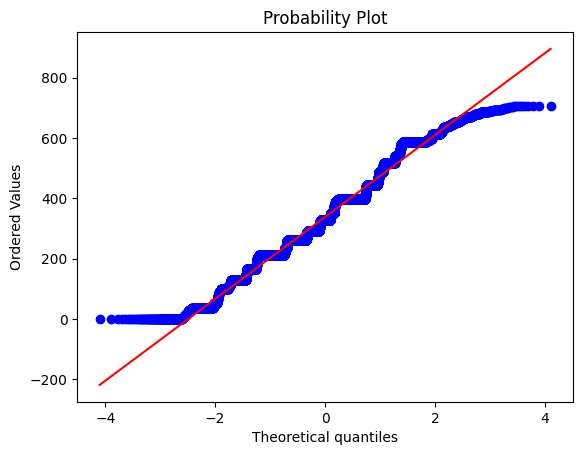

In [ ]:
sns.displot(df['Engine_capacity(cm3)'])
fig = plt.figure()
res = stats.probplot(df['Engine_capacity(cm3)'], plot=plt)

Попробуем применить логарифмическое преобразование

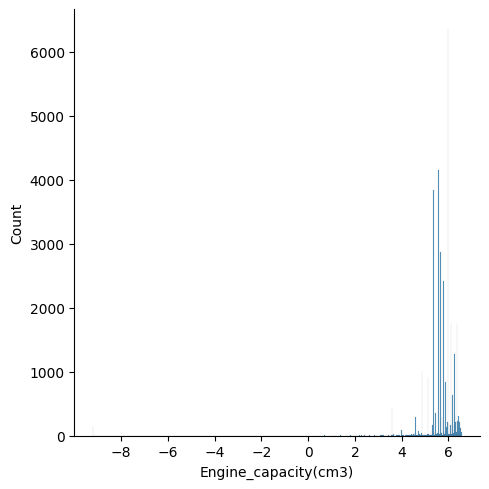

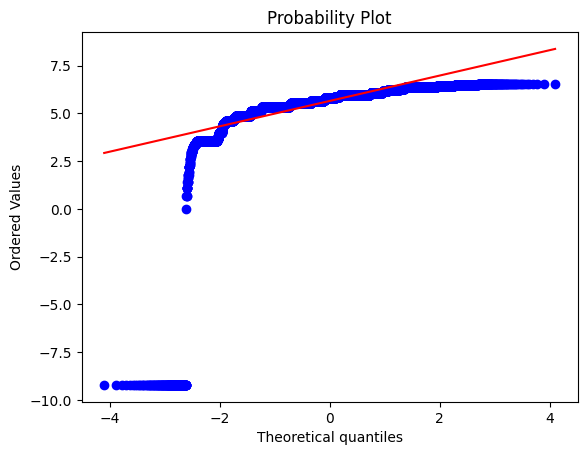

In [ ]:
a = 0.0001
sns.displot(np.log(df['Engine_capacity(cm3)']+a))
fig = plt.figure()
res = stats.probplot(np.log(df['Engine_capacity(cm3)']+a), plot=plt)

Стало хуже. Прочерим свернутый корень.

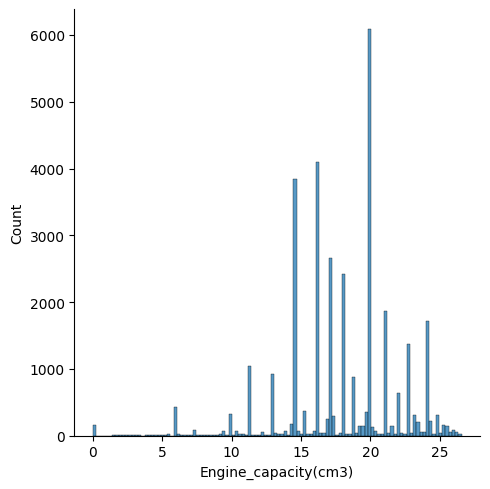

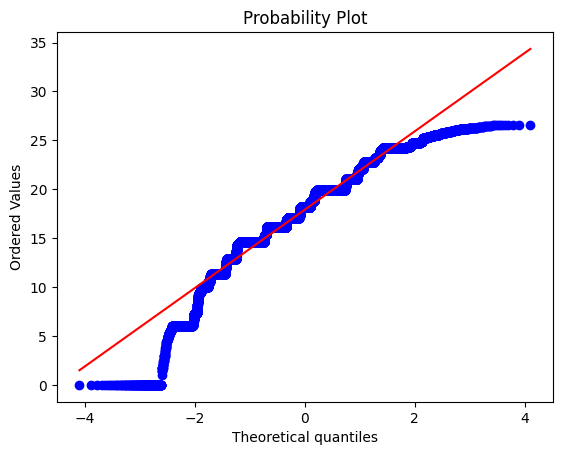

In [ ]:
sns.displot(np.sign(df['Engine_capacity(cm3)'])* np.sqrt(df['Engine_capacity(cm3)'].abs()))
fig = plt.figure()
res = stats.probplot(np.sign(df['Engine_capacity(cm3)'])* np.sqrt(df['Engine_capacity(cm3)'].abs()), plot=plt)

Поседняя попытка - кубичекий корень

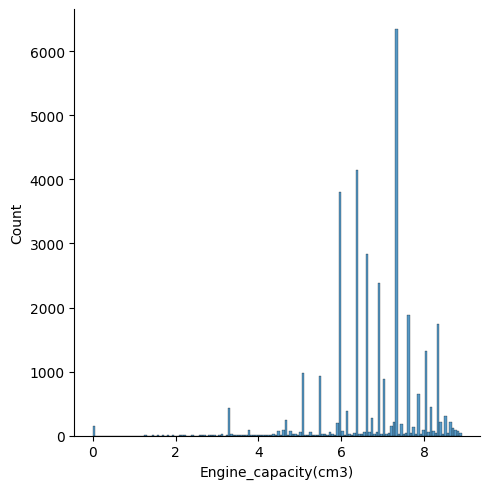

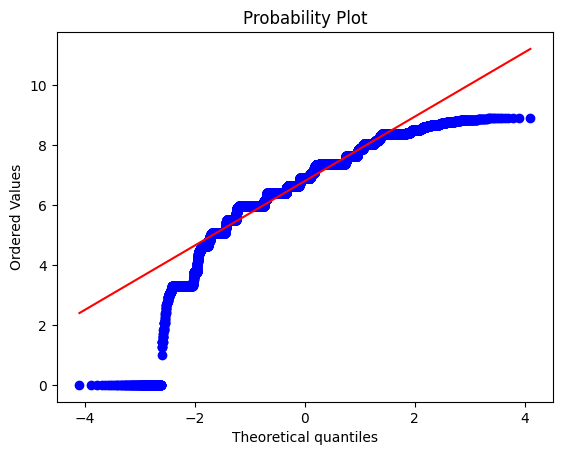

In [ ]:
sns.displot(np.sign(df['Engine_capacity(cm3)'])*(df['Engine_capacity(cm3)'].abs()**(1/3)))
fig = plt.figure()
res = stats.probplot(np.sign(df['Engine_capacity(cm3)'])*(df['Engine_capacity(cm3)'].abs()**(1/3)), plot=plt)

Любые преобразования делаю данные только хуже. Лучше никаких изменений по данному числовому значению не проиводить.

# Регрессия Методом к-Ближайших Соседей

In [ ]:
X,y = df.drop(columns = ['Price(euro)']).values,df['Price(euro)'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# нормализуем 
scaler  = MinMaxScaler()
scaler.fit(X_train) # для тренировочных сначала "обучаем"
X_train = scaler.transform(X_train) # потом преобразуем  transform  
X_test  = scaler.transform(X_test)  # для тестовых - просто transform 

Построим простую модель

In [ ]:
kNN = KNeighborsRegressor(n_neighbors=9, weights='distance' )

In [ ]:
kNN.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=9, weights='distance')

In [ ]:
y_predict=kNN.predict(X_test)

Смотрим результат

In [ ]:
print('Оценка обучающего набора: {:.4f}'.format(kNN.score(X_train, y_train)))
print('Оценка тестового набора: {:.4f}'.format(kNN.score(X_test, y_test)))

Оценка обучающего набора: 0.9992
Оценка тестового набора: 0.8162


In [ ]:
print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test,y_predict))
print('RMSE: %.1f' % mse(y_test,y_predict,squared=False))

Ошибка на тестовых данных
MSE: 25019.3
RMSE: 158.2


# Поиск Лучших Гиперпараметров с Помощью Рандомизированного Поиска#

In [ ]:
parameters = {'n_neighbors':stats.randint(1,50), 
              'weights':['uniform', 'distance']}

In [ ]:
# количество итераций               
n_iter_search = 20 

kNN_search = RandomizedSearchCV(estimator = KNeighborsRegressor(),  # оптимизируем нашу модель
                                verbose = 0,  # чтобы он всё подробно расписал. если не интересно - пишем 0
                          param_distributions=parameters , # что оптимизируем - берем из словарика
                          cv=ShuffleSplit(n_splits=5, random_state=42), # указываем тип кросс-валидации
                          n_iter = n_iter_search # количество итераций  
                          )

In [ ]:
kNN_search.fit(X_train, y_train)

kNNbest=kNN_search.best_estimator_

kNNbest.fit(X_train, y_train);

Лучший Кандидат

In [ ]:
kNN_search.best_estimator_

KNeighborsRegressor(n_neighbors=4)

#Оценим лучшего кандидата на тестовых данных# 

In [ ]:
kNN = KNeighborsRegressor(n_neighbors=4, weights='distance' )

In [ ]:
kNN.fit(X_train, y_train)
y_predict=kNN.predict(X_test)

In [ ]:
print('Оценка обучающего набора: {:.4f}'.format(kNN.score(X_train, y_train)))
print('Оценка тестового набора: {:.4f}'.format(kNN.score(X_test, y_test)))

print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test,y_predict))
print('RMSE: %.1f' % mse(y_test,y_predict,squared=False))

Оценка обучающего набора: 0.9992
Оценка тестового набора: 0.8171
Ошибка на тестовых данных
MSE: 24894.7
RMSE: 157.8


Визуализация предсказаний модели и реальных значений

In [ ]:
def print_stem(y, label, marker):
    markerline, stemlines, baseline = plt.stem(y, markerfmt=marker,label = label,use_line_collection = True, )
    markerline.set_markerfacecolor('none')

<ipython-input-72-264cb6f49b70>:2: MatplotlibDeprecationWarning:

The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.



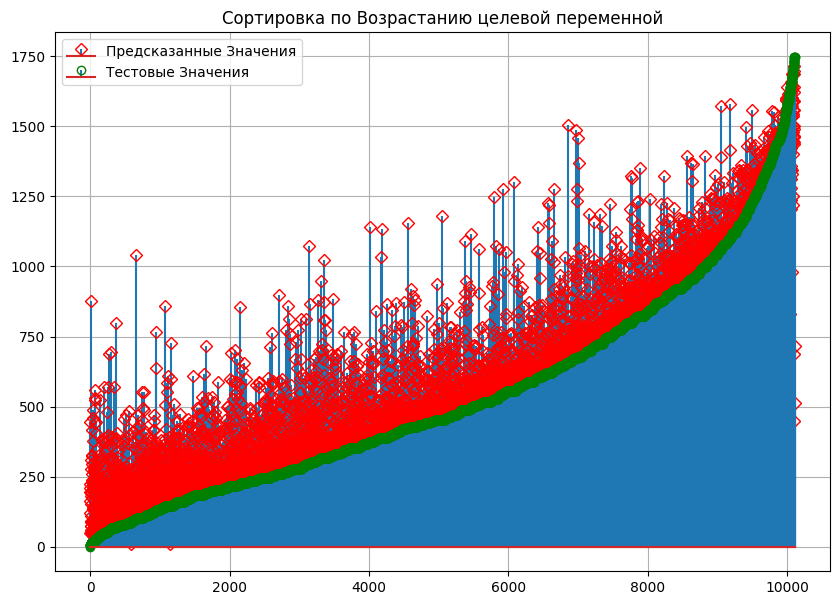

In [ ]:
fig=plt.figure(figsize=(10, 7))
sorted = np.argsort(y_test)
print_stem(y_predict[sorted], 'Предсказанные Значения', 'rD')
print_stem(y_test[sorted], 'Тестовые Значения', 'go')

plt.grid()
plt.title('Сортировка по Возрастанию целевой переменной')
plt.legend();